In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including the Markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [2]:

# -------------------------------
# CIR Simulation Function
# -------------------------------
def cir_simulation(n_sample, T, a, b, sigma, dt, seed):
    """
    Simulate the CIR process using full truncation Euler:
      dr_t = a(b - r_t) dt + sigma * sqrt(max(r_t, 0)) * dW_t
    """
    np.random.seed(seed)
    r = np.zeros((T+1, n_sample))
    r[0, :] = b  # initial condition set at the long-term mean
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        r_prev = r[t-1, :]
        r[t, :] = r_prev + a * (b - np.maximum(r_prev, 0)) * dt \
                        + sigma * np.sqrt(np.maximum(r_prev, 0)) * np.sqrt(dt) * Z
        r[t, :] = np.maximum(r[t, :], 0)  # enforce non-negativity
    return r

In [4]:
# Parameters for the CIR model with fixed mean reversion speed:
a = 2.0     # common mean reverting speed for both processes
b = 5       # long-term mean rate in percentage points

# Set volatility levels:
sigma_X = 1.5  # high volatility for process X
sigma_Y = 0.5  # low volatility for process Y

n_sample = 500  # number of sample paths for visualization
seed = 44
T = 30          # 30 time steps (days)
dt = 1 / 365    # each time step represents one day (annualized)

n_sample = 500     # number of sample paths for visualization
seed = 44

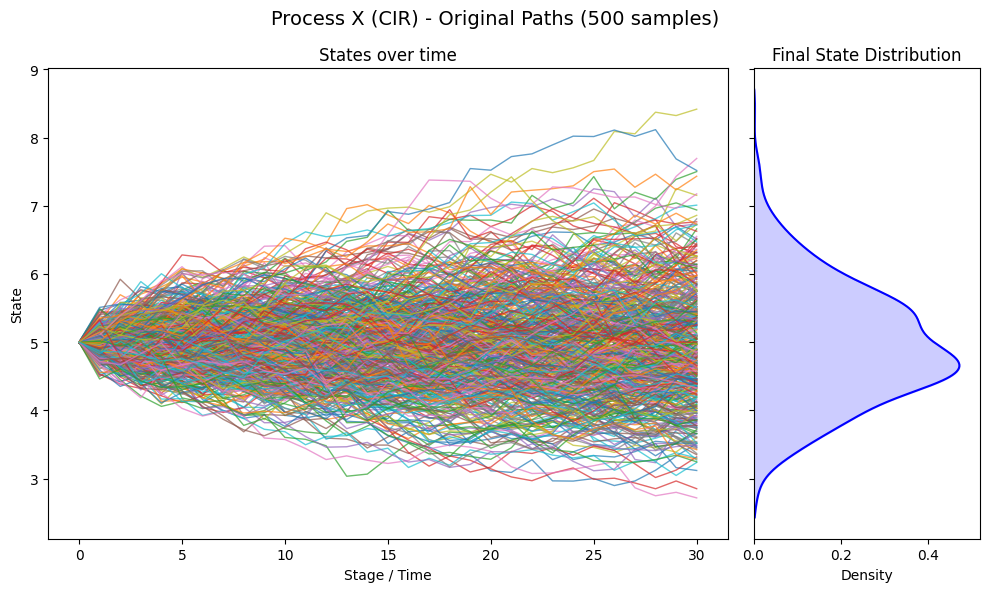

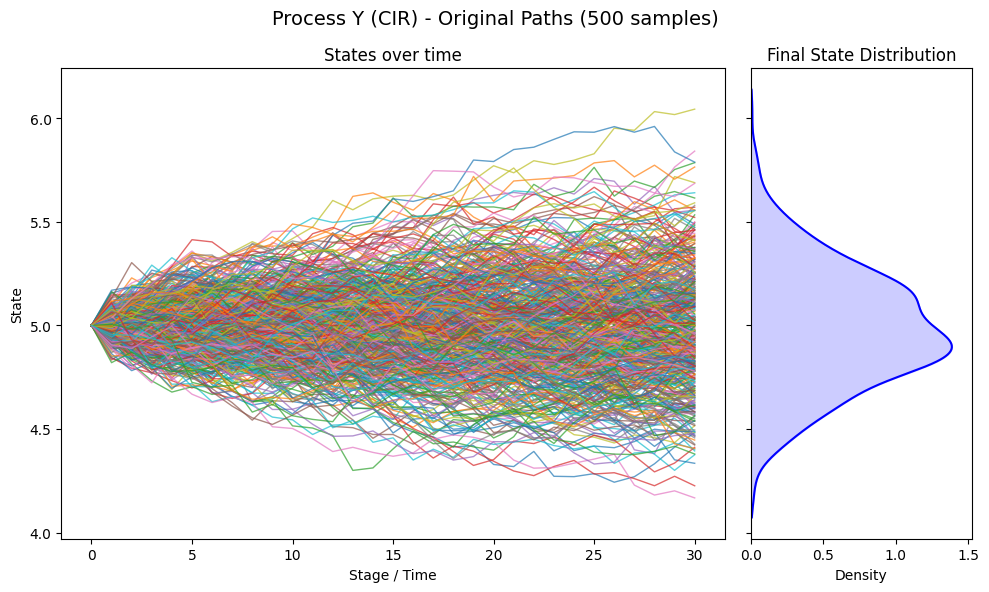

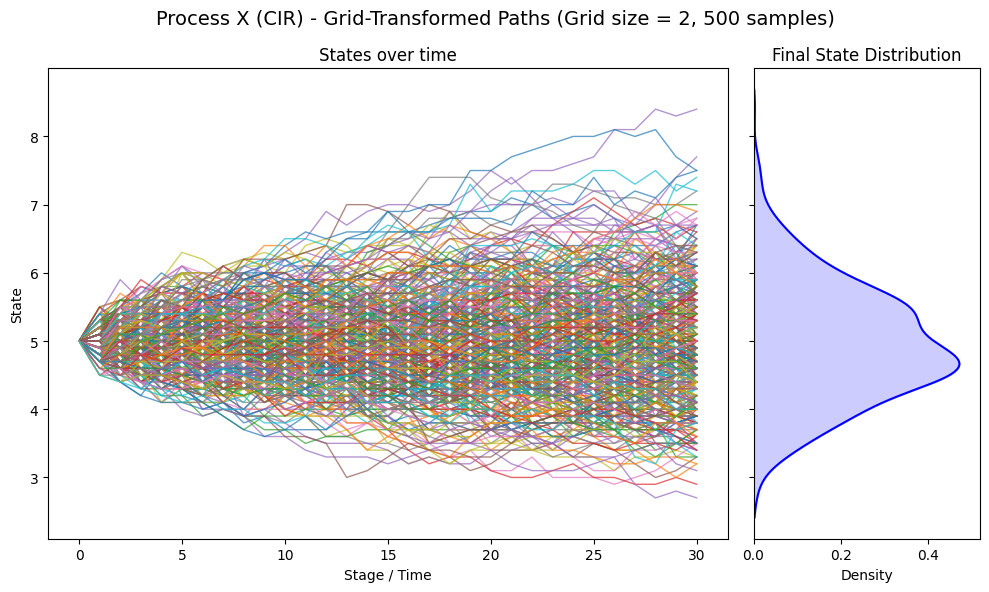

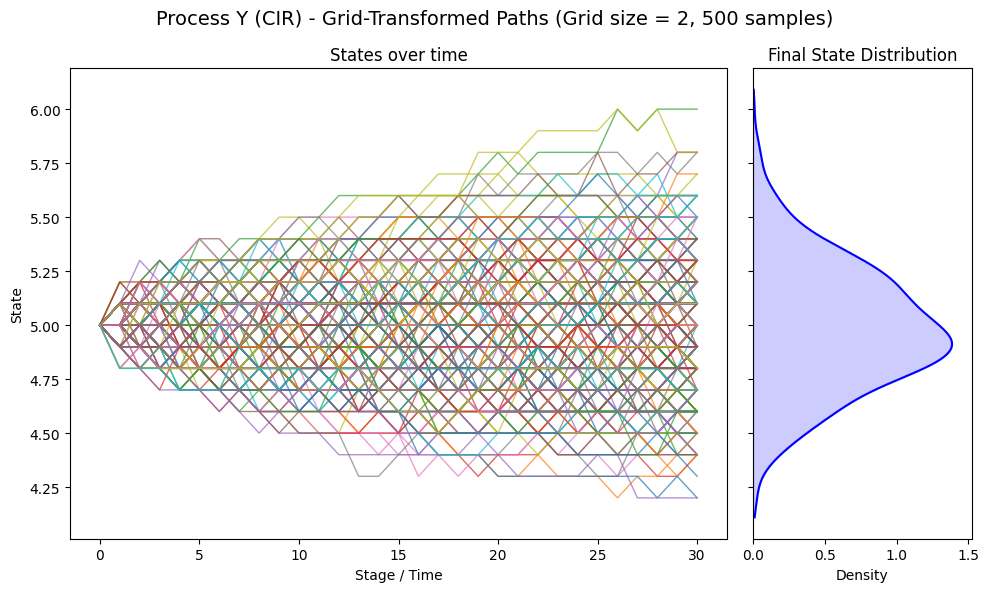

In [6]:
# Simulate CIR processes
X = cir_simulation(n_sample, T, a, b, sigma_X, dt, seed)
Y = cir_simulation(n_sample, T, a, b, sigma_Y, dt, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

# Build and visualize the tree for Process X
root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X (CIR) - Original Paths (500 samples)",
)

# Build and visualize the tree for Process Y
root = build_tree_from_paths(Y.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y (CIR) - Original Paths (500 samples)",
)

# Apply grid quantization for visualization.
fixed_grid_plot = 0.1  # use same grid size for plotting as in the BS notebook

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid_plot, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X (CIR) - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid_plot, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y (CIR) - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

In [11]:
# -------------------------------
# Experiments: Adapted Wasserstein Squared Distance via Markovian Solver
# -------------------------------

# For experiments we will use a fixed grid for quantization.
fixed_grid = 0.02

# Define sample sizes to test (adjust as needed)
sample_sizes = [30000, 50000, 80000, 120000, 180000, 250000, 500000, 750000, 1000000]
n_runs = 10

results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate a random seed for each run.
        seed = np.random.randint(10000)
        
        # Simulate the CIR processes for the given sample size.
        # Process X uses high mean reversion (a1); Process Y uses low mean reversion (a2).
        X = cir_simulation(n_sample, T, a, b, sigma_X, dt, seed)
        Y = cir_simulation(n_sample, T, a, b, sigma_Y, dt, seed)
        
        # Convert paths to adapted paths using grid quantization.
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping.
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (Markovian).
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.10f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 30000
Run 1: AW_2^2 = 5.8755683295, Time = 24.1986s
Run 2: AW_2^2 = 5.8676033630, Time = 23.9604s
Run 3: AW_2^2 = 5.7898316059, Time = 24.1465s
Run 4: AW_2^2 = 5.9319213062, Time = 23.9007s
Run 5: AW_2^2 = 5.8655518094, Time = 24.0146s
Run 6: AW_2^2 = 5.8675627784, Time = 23.9990s
Run 7: AW_2^2 = 5.9076687829, Time = 24.7004s
Run 8: AW_2^2 = 5.8012990336, Time = 24.3261s
Run 9: AW_2^2 = 5.8843365293, Time = 24.2071s
Run 10: AW_2^2 = 5.8376299814, Time = 24.4333s

Running experiments for sample size: 50000
Run 1: AW_2^2 = 5.8232701988, Time = 25.4658s
Run 2: AW_2^2 = 5.8414606780, Time = 25.2897s
Run 3: AW_2^2 = 5.8129408220, Time = 25.3588s
Run 4: AW_2^2 = 5.9065431856, Time = 25.6031s
Run 5: AW_2^2 = 5.8536771129, Time = 25.1206s
Run 6: AW_2^2 = 5.7989274220, Time = 25.1607s
Run 7: AW_2^2 = 5.8396122127, Time = 24.9421s
Run 8: AW_2^2 = 5.8525423576, Time = 25.6238s
Run 9: AW_2^2 = 5.8304597265, Time = 25.1191s
Run 10: AW_2^2 = 5.8763558199, Time =

In [12]:

aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

Sample Size: 30000
  Mean AW_2^2: 5.8629 ± 0.0415
  Mean Time: 24.1887s ± 0.2333s

Sample Size: 50000
  Mean AW_2^2: 5.8436 ± 0.0296
  Mean Time: 25.2503s ± 0.2542s

Sample Size: 80000
  Mean AW_2^2: 5.8209 ± 0.0297
  Mean Time: 25.8761s ± 0.2105s

Sample Size: 120000
  Mean AW_2^2: 5.8164 ± 0.0172
  Mean Time: 26.8599s ± 0.1940s

Sample Size: 180000
  Mean AW_2^2: 5.8094 ± 0.0099
  Mean Time: 26.9630s ± 0.5260s

Sample Size: 250000
  Mean AW_2^2: 5.8064 ± 0.0119
  Mean Time: 26.5106s ± 0.2426s

Sample Size: 500000
  Mean AW_2^2: 5.7937 ± 0.0118
  Mean Time: 28.1937s ± 0.4143s

Sample Size: 750000
  Mean AW_2^2: 5.7986 ± 0.0061
  Mean Time: 29.7399s ± 0.3926s

Sample Size: 1000000
  Mean AW_2^2: 5.7963 ± 0.0047
  Mean Time: 30.3619s ± 0.2898s



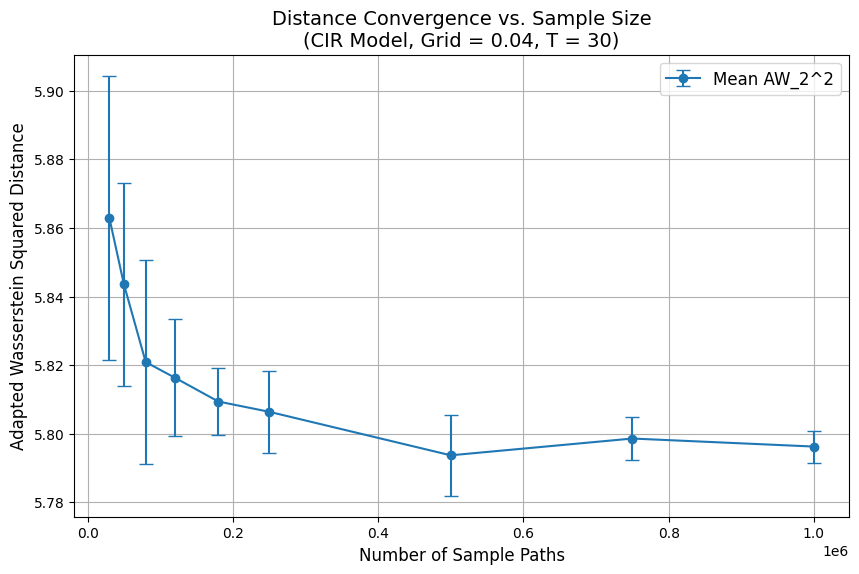

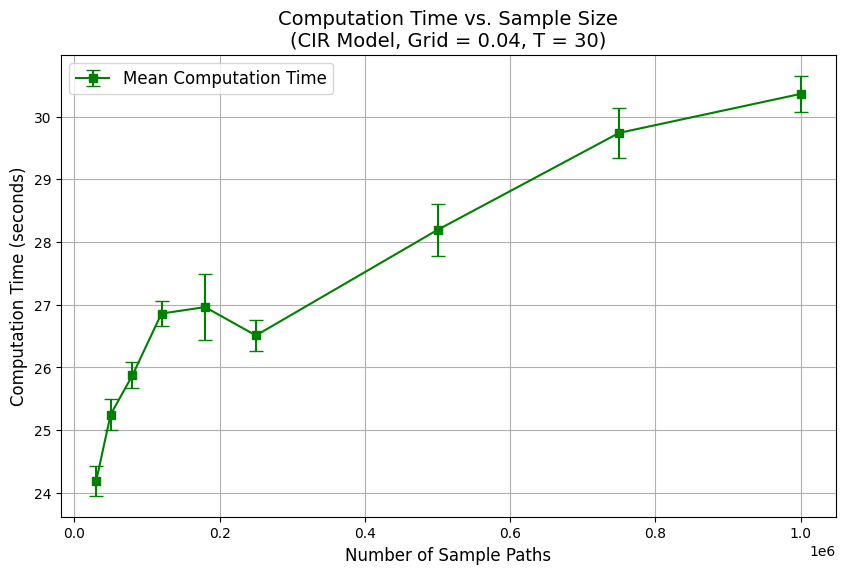

In [13]:
# -------------------------------
# Plotting the Results
# -------------------------------

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(CIR Model, Grid = 0.04, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(CIR Model, Grid = 0.04, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()